# Oridnary Least Square and Bayesian Linear Regression

In [20]:
# import libraries 
import pymc3 as pm
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.model_selection import train_test_split


In [21]:
basic_model = pm.Model()

In [22]:
print(basic_model)


Creates a new Model object which is a container for the model random variables.

This creates a context manager, with our basic_model as the context, that includes all statements until the indented block ends. This means all PyMC3 objects introduced in the indented code block below the with statement are added to the model behind the scenes. 

 When the sample function with specifications is added to the model then it samples the posterionr distribution provided by the likelihood and prior.
 
Additionally, the function specifies the type of jumps it will take across the distribution. The default is the NUTS sampler. 

In [23]:
help(pm.sample)


Help on function sample in module pymc3.sampling:

sample(draws=500, step=None, init='auto', n_init=200000, start=None, trace=None, chain_idx=0, chains=None, cores=None, tune=500, nuts_kwargs=None, step_kwargs=None, progressbar=True, model=None, random_seed=None, live_plot=False, discard_tuned_samples=True, live_plot_kwargs=None, compute_convergence_checks=True, use_mmap=False, **kwargs)
    Draw samples from the posterior using the given step methods.
    
    Multiple step methods are supported via compound step methods.
    
    Parameters
    ----------
    draws : int
        The number of samples to draw. Defaults to 500. The number of tuned
        samples are discarded by default. See discard_tuned_samples.
    step : function or iterable of functions
        A step function or collection of functions. If there are variables
        without a step methods, step methods for those variables will
        be assigned automatically.
    init : str
        Initialization method to us

In [24]:
import pandas as pd
import numpy as np

In [25]:
df = pd.read_csv("yield_forecast.csv")

In [26]:
def format_data(df,test_size):
   
    # Targets are final grade of student
    labels = df['y_pred']
    # Drop the school and the grades from features
    df = df.drop(columns=['asd_desc','state','y_pred'],axis = 1)
    
    # One-Hot Encoding of Categorical Variables
    #df = pd.get_dummies(df)
    
    #df['y'] = list(labels)
    #most_correlated = df.corr().abs()['y'].sort_values(ascending=False)
    #print(most_correlated)
    
    # Keep correlations greater than 0.2 in absolute value
    #most_correlated = most_correlated[most_correlated >= 0.2][1:]
    
    #df = df.ix[:, most_correlated.index]
    #df = df.drop(columns = 'y')
    
    # Split into training/testing sets with 25% split
    X_train, X_test, y_train, y_test = train_test_split(df, labels, 
                                                        test_size = test_size,
                                                       random_state=42)
    
    return X_train, X_test, y_train, y_test
    

In [54]:
def evaluate(X_train, X_test, y_train, y_test):
    # Names of models
    model_name = ['OLS']
    
    # Instantiate the models
    model1 = sm.OLS(y_train,X_train)
    # Dataframe for results
    results = pd.DataFrame(columns=['rmse'], index = model_name)
    
   
    fitted = model1.fit()
    #print(X_train.shape)
    #print(y_train.shape)
    #print(X_test.shape)
    print(fitted.summary())
    predictions = fitted.predict(X_test)
        
        # Metrics
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    #mape = np.median(np.divide(abs(predictions - y_test), y_test, where= y_test!=0))
        
    # Insert results into the dataframe
    results.loc[model_name, :] = [rmse]
    
    # Median Value Baseline Metrics
    baseline_mse = np.mean((np.median(y_train_yield) - y_test) ** 2)
    baseline_rmse = np.sqrt(baseline_mse)
    #baseline_mape = np.median(np.divide(abs(np.mean(y_train) - y_test), y_test, where= y_test!=0))
    #print(model1.coef_)
    #observation = pd.DataFrame({'cyield':32.8,'irig_flag':0,'dewPoint':38.41,'humidity':0.56,'temp_delta':23.567,'precipIntensity':0.001869},index=0)
    #print(model1.predict(observation))
    results.loc['Baseline', :] = [baseline_rmse]
    
    return results
        

In [55]:
# apply format data function
X_train_yield, X_test_yield, y_train_yield, y_test_yield = format_data(df,0.50)
#X_train_yield.head()

In [56]:
# apply evaluate function
yield_results = evaluate(X_train_yield, X_test_yield, y_train_yield, y_test_yield)


                            OLS Regression Results                            
Dep. Variable:                 y_pred   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     1304.
Date:                Tue, 15 May 2018   Prob (F-statistic):           1.88e-94
Time:                        06:41:51   Log-Likelihood:                -333.70
No. Observations:                 101   AIC:                             691.4
Df Residuals:                      89   BIC:                             722.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
cyield                     0

In [57]:
yield_results

,rmse
OLS,7.257577
Baseline,33.119432


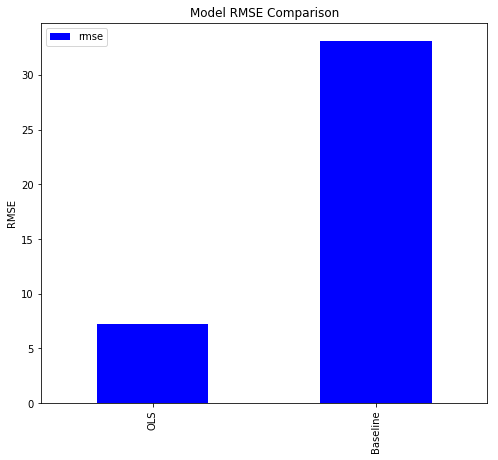

In [58]:
from IPython.core.pylabtools import figsize
figsize(8, 7)
# Root mean squared error
ax = yield_results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'b')
plt.title('Model RMSE Comparison'); plt.ylabel('RMSE');

In [60]:
## Bayesian Liner Regression


We will be using the GLM.from_formula function in PyMC3 which means we need to create a formula relating the explanatory variables (the features) to the response . The GLM.from_formula function call uses the R formula syntax which is shown below. When the model performs inference, it will draw samples from the posterior for each of the variables in the formula, along with an intercept and a variance.

In [59]:

X_train_yield['y'] = list(y_train_yield)
formula = 'y ~ ' + ' + '.join(['%s' % variable for variable in X_train_yield.columns[:-1]])
print(formula)

y ~ cyield + irig_flag + days_under0 + dewPoint + precipAccumulation + precip + days_under_n10 + days_over42 + days_over32 + humidity + temp_delta + temperatureMin + apparentTemperatureMin + precipIntensity


In [62]:
import pymc3 as pm
with pm.Model() as normal_model:
    # Error term
    # this is our model learning
    pm.GLM.from_formula(formula, X_train_yield)
    
    # Perform Markov Chain Monte Carlo sampling
    # Explain the idea of intelligent jumps and starting from the frequentist observation
    normal_trace = pm.sample(draws=2000, tune = 500, njobs=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_log__, precipIntensity, apparentTemperatureMin, temperatureMin, temp_delta, humidity, days_over32, days_over42, days_under_n10, precip, precipAccumulation, dewPoint, days_under0, irig_flag, cyield, Intercept]
100%|██████████| 2500/2500 [10:16<00:00,  4.05it/s]


The function GLM.from_formula parses the formula string, adds a random variable for each regressor and a likelihood for each random variable which by default is a normal distribution. The function then initializes the parameters (weights,  β
β
 ) to sensible starting points using a frequentists estimate provided by statsmodels.

In [61]:
help(pm.GLM.from_formula)

Help on method from_formula in module pymc3.glm.linear:

from_formula(formula, data, priors=None, vars=None, family='normal', name='', model=None, offset=0.0) method of pymc3.model.InitContextMeta instance



We can change the priors and likelihood distributions above my specifying priors and family specifically.
For example: 

In [ ]:
priors = {"Intercept": pm.Normal.dist(mu=0, sd=100),
          "Regressor": pm.Laplace.dist(mu=0, b=np.sqrt(2))
          }
family=pm.glm.families.Binomial()

In [ ]:
pm.traceplot(normal_trace)

In [ ]:
pm.summary(normal_trace)